In [18]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

class SpendAnomaliesModel:
    
    raw_data = pd.DataFrame()
    spend_data = pd.DataFrame()
    model_data = pd.DataFrame()
    date_columns = []
    
    def __init__(self, data_file_path):
        
        self.date_columns = ['[PO]PO Create Date (Date)', '[PO]PO Dispatch Date (Date)', '[INV]Voucher Create Date (Date)', \
                        '[INV]Voucher Invoice Date (Date)', '[INV]Payment Date (Date)', '[INV]Voucher Received Date B (Date)',\
                        '[INV]Accounting Date (Date)']
        
        self.raw_data = pd.read_csv(data_file_path,
                              na_values = ['Unclassified', '-', 'nan'],                        
                              thousands = ',',
                              parse_dates = self.date_columns,
                              #nrows = 100,
                              infer_datetime_format = True)
        
        print(self.raw_data.info())
        all_columns = self.raw_data.columns
        
        self.spend_data = self.raw_data[self.raw_data['[INV]Commodity (enriched) (Custom Category (L2))'] == '1050 Packaging']
        
        print(self.spend_data.shape)
        self.parse_data()
        
    def parse_data(self):
        
        for date in self.date_columns:
            self.spend_data[date] = pd.to_datetime(self.spend_data[date], 
                      errors = 'coerce', 
                      infer_datetime_format = True)
            
        print("#1) Dealing with Missing Values ....")
        
        '''
        # Requester name with unknown # check with id first
        self.spend_data['PO_Requester_Name'] = np.where(self.spend_data[
                'PO_Requester_Name'].isnull(), 'unknown', self.spend_data[
                        'PO_Requester_Name'])
        
        # PO_Terms missing Values
        self.spend_data['PO_Terms'] = np.where(self.spend_data['PO_Terms'].isnull(), 
                                     self.spend_data['INV_Voucher_Terms'],
                                     self.spend_data['PO_Terms'])

        self.spend_data['INV_Voucher_Terms'] = np.where(self.spend_data['INV_Voucher_Terms'].isnull(), 
                                             self.spend_data['PO_Terms'],
                                             self.spend_data['INV_Voucher_Terms'])
                                             
        '''
        
        self.spend_data['[PO]PO Terms (PO Terms)'].fillna('0', inplace = True)
        
        self.spend_data['[INV] Voucher Terms'].fillna('0', inplace = True)

        
        # UOM_Missing values 
        # UOM of PO and Voucher are mostly same
        # IF PO UOM are missing fillinf it with voc uOM
        '''
        self.spend_data['PO_UOM'] = np.where(self.spend_data['PO_UOM'].isnull(),
                  self.spend_data['INV_UOM'], self.spend_data['PO_UOM'])
        
        
        # IF Voc UOM are missing filling it with 
        self.spend_data['INV_UOM'] = np.where(self.spend_data['INV_UOM'].isnull(),
                  self.spend_data['PO_UOM'], self.spend_data['INV_UOM'])
                  
        '''
        
        # UOM _Missing Values
        self.spend_data['[INV]Unit Of Measure (Unit of Measure)'] = np.where(self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].isnull(),
                 'unknown', self.spend_data['[INV]Unit Of Measure (Unit of Measure)'])
        
        
        self.spend_data['[PO]UOM (Unit of Measure)'] = np.where(self.spend_data['[PO]UOM (Unit of Measure)'].isnull(),
                  'unknown', self.spend_data['[PO]UOM (Unit of Measure)'])
        
       
        # PO_Internal_Part_Number should be mandatory
        # Filling it with -1 to make it distinctable
        self.spend_data['[INV]Part (Internal Part Number)'] = np.where(
                self.spend_data['[INV]Part (Internal Part Number)'].isnull(),
                -1,
                self.spend_data['[INV]Part (Internal Part Number)'])
        
        # Removing the preceding zeroes from the item id
        self.spend_data['[INV]Part (Internal Part Number)'] = self.spend_data[
        '[INV]Part (Internal Part Number)'].apply(lambda x : str(x).lstrip('0'))
        
        #Removing remaining null values from imp cols
        self.spend_data.dropna(subset = self.date_columns, inplace = True)
              
        self.spend_data['[PO]Part (Part Name)'] = self.spend_data['[PO]Part (Part Name)'
                  ].apply(lambda x : str(x).lstrip('0'))
        
        print('#2) Extracting number from PO terms')
        
        self.spend_data['PO_Disc_Days'] = self.spend_data['[PO]PO Terms (PO Terms)'].apply(
                lambda x : re.findall(r"(?<=/)[0-9][0-9]", str(x), re.I))
        
        self.spend_data['PO_Disc_Days'] = self.spend_data['PO_Disc_Days'].apply(
                lambda x : x[0]  if x  else 0)
        
        
        self.spend_data['PO_Days_To_Pay'] = self.spend_data['[PO]PO Terms (PO Terms)'].apply(
                lambda x : re.findall(r' [0-9][0-9]|(?<=NET)[0-9][0-9]', str(x),
                                      re.I))
        
        self.spend_data['PO_Days_To_Pay'] = self.spend_data['PO_Days_To_Pay'].apply(
                lambda x : x[0]  if x  else 0)
        
        print("#3 Extracting invoice terms")
        
        self.spend_data['Inv_Disc_Days'] = self.spend_data['[INV] Voucher Terms'].apply(
                lambda x : re.findall(r"(?<=/)[0-9][0-9]|\d+ days \d+", str(x)))
        
        self.spend_data['Inv_Disc_Days'] = self.spend_data['Inv_Disc_Days'].apply(
                lambda x : "".join(x))
        
        self.spend_data['Inv_Disc_Days'] = self.spend_data['Inv_Disc_Days'].apply(
                lambda x : re.findall(r'\d+', x))
        
        self.spend_data['Inv_Disc_Days'] = self.spend_data['Inv_Disc_Days'].apply(
                lambda x : x[0]  if x  else 0)
    
        self.spend_data['Inv_Days_To_Pay'] = self.spend_data['[INV] Voucher Terms'].apply(
                lambda x : re.findall(r"\d+$|\d+ days?", str(x), re.I))
        
        self.spend_data['Inv_Days_To_Pay'] = self.spend_data['Inv_Days_To_Pay'].apply(
                lambda x : x[0]  if len(x)==1 else (x[1] if len(x)==2 else 0))
        
        self.spend_data['Inv_Days_To_Pay'] = self.spend_data['Inv_Days_To_Pay'].apply(
                lambda x : re.findall(r'\d+', str(x)))
        
        self.spend_data['Inv_Days_To_Pay'] = self.spend_data['Inv_Days_To_Pay'].apply(
                lambda x : ''.join(x))
    
        self.spend_data[['PO_Disc_Days', 'PO_Days_To_Pay', 'Inv_Disc_Days', 
                    'Inv_Days_To_Pay']] = self.spend_data[['PO_Disc_Days', 
                                      'PO_Days_To_Pay', 'Inv_Disc_Days', 
                                      'Inv_Days_To_Pay']].astype('int', inplace = True)
        
        print("#4 Correcting Voucher Quantity when there are returns")
        
        self.spend_data['sum(Voucher Quantity)'] =  np.where(self.spend_data['sum(Voucher amount USD)'] < 0, \
                                         -np.absolute(self.spend_data['sum(Voucher Quantity)']), self.spend_data['sum(Voucher Quantity)'])
        
        
        print("#5. Actual  Voucher_Unit_Price Calculation")
        self.spend_data['sum(Voucher Unit Price)'] = self.spend_data['sum(Voucher Unit Price)'] / self.spend_data['count(InvoiceLineItem)']
        
        print("#6. Different Units of Measure - adjusting PO, VO quantities")
        
        #If the UOMs are different and the voucher quantity is 0, then make both UOMs the same -  
        # the quantity difference is going to be retained.
        self.spend_data['[PO]UOM (Unit of Measure)'] = np.where(self.spend_data['sum(Voucher Quantity)'] == 0, \
                                       self.spend_data['[INV]Unit Of Measure (Unit of Measure)'], self.spend_data['[PO]UOM (Unit of Measure)'])
        
        #If the UOMs are different and the voucher quantity is equal to PO quantity, make the UOMs the same.
        self.spend_data['[PO]UOM (Unit of Measure)'] = np.where(self.spend_data['sum(Voucher Quantity)'] == self.spend_data['sum(PO line quantity)'], \
                                       self.spend_data['[INV]Unit Of Measure (Unit of Measure)'], self.spend_data['[PO]UOM (Unit of Measure)'])
        
        #Doing valid conversions - pound to kilogram - 1 kilogram = 2.20462 pounds
        # meter to foot - 1 meter = 3.28084 feet
        # km to meter - 1 km = 1000 meters
        # kg to gram - 1 kg = 1000 grams
        
        #pound to kilogram - doing the conversion
        
        self.spend_data['sum(Voucher Quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'pound') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='kilogram'), \
                                                   self.spend_data['sum(Voucher Quantity)'] / 2.20462,  self.spend_data['sum(Voucher Quantity)'] )
        
        #Making units the same after conversion                        
        self.spend_data['[INV]Unit Of Measure (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'pound') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='kilogram'), \
                                                     'kilogram', self.spend_data['[INV]Unit Of Measure (Unit of Measure)'])
        
        self.spend_data['sum(PO line quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'kilogram') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='pound'), \
                                                   self.spend_data['sum(PO line quantity)'] / 2.20462,  self.spend_data['sum(PO line quantity)'] )
        
                                
        self.spend_data['[PO]UOM (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'kilogram') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='pound'), \
                                                     'kilogram', self.spend_data['[PO]UOM (Unit of Measure)'])
            
        #foot to meter
        self.spend_data['sum(Voucher Quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'foot') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='meter'), \
                                                   self.spend_data['sum(Voucher Quantity)'] / 3.28084,  self.spend_data['sum(Voucher Quantity)'] )
        
                                
        self.spend_data['[INV]Unit Of Measure (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'foot') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='meter'), \
                                                     'meter', self.spend_data['[INV]Unit Of Measure (Unit of Measure)'])
        
        self.spend_data['sum(PO line quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'meter') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='foot'), \
                                                   self.spend_data['sum(PO line quantity)'] / 3.28084,  self.spend_data['sum(PO line quantity)'] )
        
                                
        self.spend_data['[PO]UOM (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'meter') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='foot'), \
                                                     'meter', self.spend_data['[PO]UOM (Unit of Measure)'])
        
        #meter to km
        self.spend_data['sum(Voucher Quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'meter') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='km'), \
                                                   self.spend_data['sum(Voucher Quantity)'] / 1000,  self.spend_data['sum(Voucher Quantity)'] )
        
                                
        self.spend_data['[INV]Unit Of Measure (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'meter') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='km'), \
                                                     'km', self.spend_data['[INV]Unit Of Measure (Unit of Measure)'])
        
        self.spend_data['sum(PO line quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'km') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='meter'), \
                                                   self.spend_data['sum(PO line quantity)'] / 1000,  self.spend_data['sum(PO line quantity)'] )
        
                                
        self.spend_data['[PO]UOM (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'km') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='meter'), \
                                                     'km', self.spend_data['[PO]UOM (Unit of Measure)'])
        
        #gram to kilogram
        self.spend_data['sum(Voucher Quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'gram') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='kilogram'), \
                                                   self.spend_data['sum(Voucher Quantity)'] / 1000,  self.spend_data['sum(Voucher Quantity)'] )
        
                                
        self.spend_data['[INV]Unit Of Measure (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'gram') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='kilogram'), \
                                                     'kilogram', self.spend_data['[INV]Unit Of Measure (Unit of Measure)'])
        
        self.spend_data['sum(PO line quantity)'] = \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'kilogram') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='gram'), \
                                                   self.spend_data['sum(PO line quantity)'] / 1000,  self.spend_data['sum(PO line quantity)'] )
        
                                
        self.spend_data['[PO]UOM (Unit of Measure)'] =  \
            np.where((self.spend_data['[INV]Unit Of Measure (Unit of Measure)'].str.lower() == 'kilogram') & (self.spend_data['[PO]UOM (Unit of Measure)'].str.lower() =='gram'), \
                                                     'kilogram', self.spend_data['[PO]UOM (Unit of Measure)'])
        
        #Remove other rows which have different UOMs
        self.spend_data['diffUOM'] = (self.spend_data['[PO]UOM (Unit of Measure)'] == self.spend_data['[INV]Unit Of Measure (Unit of Measure)'])
        
        self.spend = self.spend_data[self.spend_data['diffUOM'] == False]
        
        self.create_features()
        
        
        
    def create_features(self):
        
        # Taking the unique of PO amount As PO Amount got duplicated
        # due to diff number of vouchers raised against same PO
        self.spend_data['total_PO_Amount'] = self.spend_data.groupby(['[INV] PO Id', 
                  '[INV] PO Id'])['sum(PO Amount)'].transform('unique')
            

        self.spend_data['total_PO_Amount'] = self.spend_data['total_PO_Amount'].apply(
                lambda x : sum(x) if isinstance(x, np.ndarray) else x)
               
        # Doing the same with quantity
        self.spend_data['total_PO_quantity'] = self.spend_data.groupby(['[INV] PO Id', 
                  '[INV] PO Line'])['sum(PO line quantity)'].transform('unique')
        
        self.spend_data['total_PO_quantity'] = self.spend_data['total_PO_quantity'
                ].apply(lambda x : sum(x) if isinstance(x, np.ndarray) else x)
               
        ## Calculating total voucher amount and quantity received 
        self.spend_data['total_voucher_amount']= self.spend_data.groupby(['[INV] PO Id', 
                  '[INV] PO Line'])['sum(Voucher Amount)'].transform('sum')
        
        self.spend_data['total_voucher_quantity']= self.spend_data.groupby(['[INV] PO Id', 
                  '[INV] PO Line'])['sum(Voucher Quantity)'].transform('sum')
      
        
        #self.spend_data = self.spend_data
        
        # Some times we receive voucher quantity less that PO quantity; so
        # we need to calculate PO amount based on the voucher quantity received
        self.spend_data['po_amount_voucher_quantity'] = ((self.spend_data['total_PO_Amount'
           ] / self.spend_data['total_PO_quantity']) * self.spend_data['total_voucher_quantity'])
        
        '''
        #Calulating PO based on logic
        # Why do we need this feature?
        #1.if VOC qty is more than PO - take original PO amt
        #2.if voc qty is less than PO - cal PO amt based on voc qty received
        self.spend_data['po_amt_based_on_voc_qty'] = np.where(self.spend_data[
                'total_voucher_quantity'] <= self.spend_data[
                        'total_PO_quantity'], self.spend_data[
                                'po_amount_of_voucher_quantity'
                                ], self.spend_data['total_PO_Amount'])
                                
        '''
        
        
        self.spend_data['qty(PO-Voc)'] = np.round(self.spend_data['total_PO_quantity'] - \
                                                  self.spend_data['total_voucher_quantity'], 2)
        
        '''
        #Not using this feature
        self.spend_data['rel_diff_in_qty'] = np.round((self.spend_data['qty(PO-Voc)']/
                  self.spend_data['total_PO_quantity']) * 100)
        '''
        
        #self.spend_data['amt_diff(PO-Voc)'] = np.round(self.spend_data['po_amt_based_on_voc_qty'] - self.spend_data['total_voucher_amount'], 2)
        
    
        self.spend_data['amt_diff(PO-Voc)'] = np.round(self.spend_data['total_PO_Amount'] - \
                                                       self.spend_data['total_voucher_amount'], 2)
        
        # Date Related Features
        
        # PO Create Date should be more than PO Dispatch
        self.spend_data['po_dispatch-po_create'] = (self.spend_data['[PO]PO Dispatch Date (Date)'] - \
                                                    self.spend_data['[PO]PO Create Date (Date)']).dt.days.astype('int')
        
        # Voc create date should be later than voc rev
        self.spend_data['voc_create_date-voc_rec_date'] = (self.spend_data['[INV]Voucher Create Date (Date)'] - \
                                                self.spend_data['[INV]Voucher Received Date B (Date)']).dt.days.astype('int')
              
        # voc inv date should come before voc rev date
        self.spend_data.dropna(subset = ['[INV]Voucher Invoice Date (Date)'], inplace = True)
        
        self.spend_data['voc_rev_date-voc_inv_date'] = (self.spend_data['[INV]Voucher Received Date B (Date)'] - \
                                            self.spend_data['[INV]Voucher Invoice Date (Date)']).dt.days.astype('int')
        
        
        # PO create date should come before PO recv date
        self.spend_data['voc_rev_date-po_create_date'] = (self.spend_data['[INV]Voucher Received Date B (Date)'] - \
                                  self.spend_data['[PO]PO Create Date (Date)']).dt.days.astype('int')
        
        # Accounting date should come late than PO date
        self.spend_data['accounting_date-po_create_date'] = (self.spend_data['[INV]Accounting Date (Date)'] - \
                                    self.spend_data['[PO]PO Create Date (Date)']).dt.days.astype('int')
        
        # Payment_Date - Voc Rec Date for Early payment
        self.spend_data['payment_after_days'] = (self.spend_data['[INV]Accounting Date (Date)'] - \
                                    self.spend_data['[INV]Voucher Received Date B (Date)']).dt.days.astype('int')
        
        ### Unit price variation 
        ### Actual unit price is unit price/count of line item
        ### Few unit price is in negative making it positive
        ### For some PO unit price is 0
        self.spend_data.dropna(subset = ['[PO]Part (Internal Part Number)'], axis = 0,
                          inplace = True)
        
        self.spend_data['Voucher_Unit_Price_Range'] = self.spend_data.groupby(
                ['[INV] PO Id', '[INV] PO Line', '[PO]Part (Internal Part Number)'])[
        'sum(Voucher Unit Price)'].transform(np.ptp)
        
        
        model_features = ['qty(PO-Voc)', 'amt_diff(PO-Voc)', 'Voucher_Unit_Price_Range', 'payment_after_days', \
                        'po_dispatch-po_create', 'voc_create_date-voc_rec_date', 'voc_rev_date-voc_inv_date',\
                         'voc_rev_date-po_create_date','accounting_date-po_create_date' ]
        
        self.model_data = self.spend_data[model_features]
        
        self.model_data.to_csv('features.csv')
        self.create_and_train_model()
        
    def create_and_train_model(self):
        
        X = StandardScaler().fit_transform(self.model_data)

        pca = PCA(n_components=3)

        new_features = pca.fit_transform(X)
        new_dataset = pd.DataFrame(data = new_features,
              columns = ['Principal component 1', 'Principal component 2', 'Principal component 3'])
        
        kmeans = KMeans(n_clusters=2, max_iter=500, n_init=100, random_state=0).fit(X)
        self.model_data["clusters"] = kmeans.labels_
        
        fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
        
        ax = Axes3D(fig)
        
        #targets = [0, 1, 2, 3]
        targets = [0,1]
        #targets = [0,1,2]
        colors = ['red', 'yellow', 'm', 'c']
        markers = ['*', 'o', '*', 'o']
        for target, color, marker in zip(targets,colors, markers):
            indices_target = kmeans.labels_ == target
            xs = new_dataset.loc[indices_target, 'Principal component 1']
            ys = new_dataset.loc[indices_target, 'Principal component 2']
            zs = new_dataset.loc[indices_target, 'Principal component 3']
            ax.scatter(xs, ys, zs, c=color, marker=marker, s = 100, alpha = 0.25)

            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.set_zlabel('Principal Component 3')
            ax.set_title('3D View of the Clusters', fontsize = 20)

        plt.show()
                      

C:\Users\monica.sam\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2901: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35160 entries, 0 to 35159
Data columns (total 95 columns):
[INV]Payment Date (Fiscal Year)                                                1868 non-null object
[INV]Company Site (Division)                                                   35158 non-null object
[INV]Accounting Date (Quarter)                                                 35160 non-null object
[INV]Cost Center (GL Business Unit)                                            35160 non-null object
[INV]Company Site (International Regions)                                      35158 non-null object
[INV]Company Site (Operating Unit Id)                                          35158 non-null object
[INV]Company Site (OU Description)                                             35158 non-null object
[INV]Corning Source System (Corning Source System)                             35160 non-null object
[INV]BU Description (PO BU)                                                    35160

#4 Correcting Voucher Quantity when there are returns
#5. Actual  Voucher_Unit_Price Calculation
#6. Different Units of Measure - adjusting PO, VO quantities


C:\Users\monica.sam\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


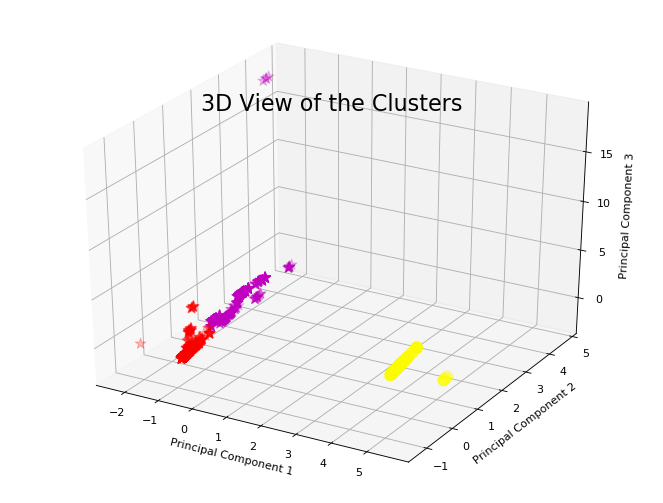

In [19]:
if __name__ == "__main__":
    sm = SpendAnomaliesModel('./Packaging_data.csv')  

In [ ]:

''''''''''''''''


''''''''''''[[';,,.....;[''';;;';////////////////////////////////////////;[0.................................................................................................................................................................]']']]